In [6]:
import pandas as pd
import seaborn as sns
import os

In [11]:
pd.read_csv(r'C:\Users\Stefan Kniejski\OneDrive\Desktop\theater_sales.csv').head()

,Year,Tickets Sold,Total Box Office,Total Inflation,Adjusted Box Office,Average Ticket Price
0,2023,922137633,\t$9710109274,\t$9710109274,\t$10.53,NaN
1,2022,709677708,\t$7425608770,\t$7425608842,\t$10.53,NaN
2,2021,434086383,\t$4514298818,\t$4542443837,\t$10.40,NaN
3,2020,211336307,\t$1988111579,\t$2205648319,\t$9.41,NaN
4,2019,1227673842,\t$11245494999,\t$12829297880,\t$9.16,NaN


In [14]:
df_theater_sales = (
    pd.read_csv((r'C:\Users\Stefan Kniejski\OneDrive\Desktop\theater_sales.csv'))
    .assign(
        total_box_office = lambda x:x['Total Box Office'].str.replace('[^0-9.]','',regex=True),
        adjusted_box_office = lambda x:x['Total Inflation'].str.replace('[^0-9.]','',regex=True),
        tickets_sold = lambda x:x['Tickets Sold'],
        average_ticket_price = lambda x:x['Adjusted Box Office'].str.replace('[^0-9.]','',regex=True),
    )
    .drop(['Total Box Office','Total Inflation', 'Adjusted Box Office'], axis=1)
    .rename({'Year':'year'}, axis=1)
    .astype(
        {
            'total_box_office':float,
            'adjusted_box_office':float,
            'average_ticket_price':float,
            'tickets_sold':int,
            'year':int
        }
    )
)


df_theater_sales.head()

,year,Tickets Sold,Average Ticket Price,total_box_office,adjusted_box_office,tickets_sold,average_ticket_price
0,2023,922137633,NaN,9.710109e+09,9.710109e+09,922137633,10.53
1,2022,709677708,NaN,7.425609e+09,7.425609e+09,709677708,10.53
2,2021,434086383,NaN,4.514299e+09,4.542444e+09,434086383,10.40
3,2020,211336307,NaN,1.988112e+09,2.205648e+09,211336307,9.41
4,2019,1227673842,NaN,1.124549e+10,1.282930e+10,1227673842,9.16


In [16]:
df_streaming_sub = (
    pd.read_csv(r"C:\Users\Stefan Kniejski\OneDrive\Desktop\streaming annual subscribers.csv")
    .melt(id_vars='Subscribers(mm)', var_name='year',value_name='subscribers')
    .rename(
        {
            'Subscribers(mm)':'company'
        },
        axis=1
    )
    .astype(
        {
            'year':int
        }
    )
)

df_streaming_sub.head()

,company,year,subscribers
0,Netflix,2018,124.35
1,Hulu,2018,20.10
2,HBO Max,2018,0.00
3,Disney Plus,2018,0.00
4,Netflix,2019,151.56


In [18]:
df_streaming_rev = (
    pd.read_csv(r"C:\Users\Stefan Kniejski\OneDrive\Desktop\streaming annual revenue.csv")
    .melt(id_vars='Revenue ($bn)', var_name='year',value_name='revenue')
    .rename(
        {
            'Revenue ($bn)':'company'
        },
        axis=1
    )
    .astype(
        {
            'year':int
        }
    )
)

df_streaming_rev.head()

,company,year,revenue
0,Netflix,2018,15.7
1,Hulu,2018,0.0
2,HBO Max,2018,0.0
3,Disney Plus,2018,0.0
4,Netflix,2019,20.1


In [19]:
(
    df_streaming_rev
    .groupby('year')
    .agg(
        total_streaming_revenue = ('revenue',sum)
    )
    .merge(
        df_theater_sales
        .loc[:,['year','adjusted_box_office']],
        on='year',
        how='inner'
    )
        .rename(
        {
            'total_streaming_revenue':'streaming',
            'adjusted_box_office':'theater',
        },
        axis=1
    )
        .assign(
        total = lambda x:x['streaming']*1e9 + x['theater'],
        streaming_pct = lambda x:x['streaming']*1e9/x['total']
    )
)

,year,streaming,theater,total,streaming_pct
0,2018,15.70,1.369433e+10,2.939433e+10,0.534117
1,2019,23.80,1.282930e+10,3.662930e+10,0.649753
2,2020,43.82,2.205648e+09,4.602565e+10,0.952078
3,2021,51.75,4.542444e+09,5.629244e+10,0.919306
4,2022,55.84,7.425609e+09,6.326561e+10,0.882628


<Axes: title={'center': 'Percent of total revenue due to streaming'}, xlabel='year', ylabel='revenue in $bn'>

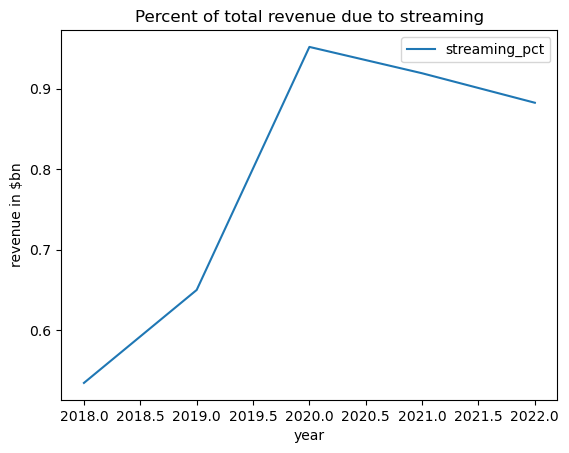

In [20]:
# streaming as a percent of total revenue:

(
        df_streaming_rev
    .groupby('year')
    .agg(
        total_streaming_revenue = ('revenue',sum)
    )
    .merge(
        df_theater_sales
        .loc[:,['year','adjusted_box_office']],
        on='year',
        how='inner'
    )
        .rename(
        {
            'total_streaming_revenue':'streaming',
            'adjusted_box_office':'theater',
        },
        axis=1
    )
        .assign(
        total = lambda x:x['streaming']*1e9 + x['theater'],
        streaming_pct = lambda x:x['streaming']*1e9/x['total']
    )
    .plot(
        kind='line',
        x='year',
        y='streaming_pct',
        title='Percent of total revenue due to streaming',
        ylabel='revenue in $bn'
    )
)

In [21]:
plot_df = (
    df_streaming_sub
    .merge(
        df_streaming_rev,
        on=['company','year'],
        how='left'
    )
    .assign(
        revenue_per_subscriber = lambda x:x['revenue']/x['subscribers']*(1e9)/(1e6)
    )
)

<Axes: xlabel='year', ylabel='revenue_per_subscriber'>

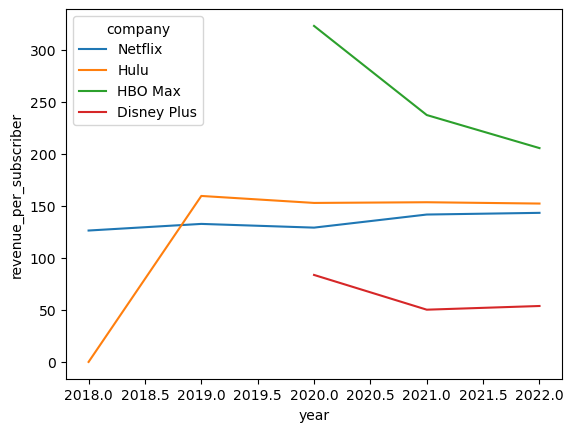

In [22]:
sns.lineplot(data=plot_df, x='year', y='revenue_per_subscriber', hue='company')

C:\Users\Stefan Kniejski\AppData\Local\Temp\ipykernel_34172\3039331899.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot('year','company', 'revenue_per_subscriber')


<Axes: xlabel='year'>

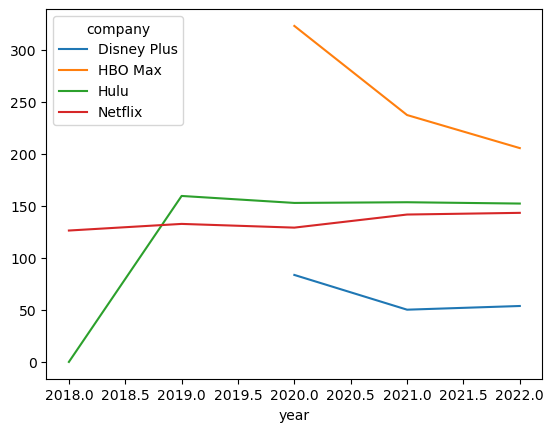

In [23]:
(
    plot_df
    .pivot('year','company', 'revenue_per_subscriber')
    .plot(kind='line')
)

In [24]:
df_streaming_rev

,company,year,revenue
0,Netflix,2018,15.70
1,Hulu,2018,0.00
2,HBO Max,2018,0.00
3,Disney Plus,2018,0.00
4,Netflix,2019,20.10
5,Hulu,2019,3.70
6,HBO Max,2019,0.00
7,Disney Plus,2019,0.00
8,Netflix,2020,24.90
9,Hulu,2020,4.40


In [25]:
df_limits = (
    df_streaming_rev
    .groupby('year')
    .agg(
        median = ('revenue',lambda x:x.quantile([.5])),
        lower = ('revenue',lambda x:x.quantile([.25])),
        upper = ('revenue',lambda x:x.quantile([.75]))
    )
    .assign(
        iqr = lambda x:x['upper'] - x['lower'],
        upper_cutoff = lambda x:x['upper'] + 1.5 * x['iqr'],
        lower_cutoff = lambda x:x['lower'] - 1.5 * x['iqr'],
        
    )
)

df_limits.head()

,median,lower,upper,iqr,upper_cutoff,lower_cutoff
year,,,,,,
2018,0.000,0.000,3.9250,3.9250,9.81250,-5.88750
2019,1.850,0.000,7.8000,7.8000,19.50000,-11.70000
2020,8.060,4.000,15.0150,11.0150,31.53750,-12.52250
2021,8.475,5.650,15.7625,10.1125,30.93125,-9.51875
2022,8.970,7.125,15.8050,8.6800,28.82500,-5.89500


In [26]:
# Outliers are all Netflix, which indicates Netflix is a much larger company than their competitors

(
    df_streaming_rev
    .merge(
        df_limits,
        on='year'
    )
    .assign(
        outlier = lambda x:(x['revenue'] > x['upper_cutoff']) | (x['revenue'] < x['lower_cutoff'])
    )
    .query("outlier==True")
)

,company,year,revenue,median,lower,upper,iqr,upper_cutoff,lower_cutoff,outlier
0,Netflix,2018,15.7,0.00,0.000,3.925,3.925,9.8125,-5.8875,True
4,Netflix,2019,20.1,1.85,0.000,7.800,7.800,19.5000,-11.7000,True
16,Netflix,2022,31.6,8.97,7.125,15.805,8.680,28.8250,-5.8950,True


<Axes: xlabel='year', ylabel='revenue'>

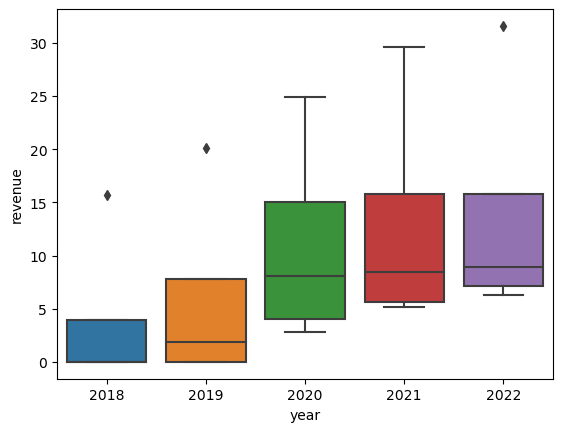

In [27]:
sns.boxplot(data=df_streaming_rev, x='year', y='revenue')

In [28]:
df_theater_sales.head()

,year,Tickets Sold,Average Ticket Price,total_box_office,adjusted_box_office,tickets_sold,average_ticket_price
0,2023,922137633,NaN,9.710109e+09,9.710109e+09,922137633,10.53
1,2022,709677708,NaN,7.425609e+09,7.425609e+09,709677708,10.53
2,2021,434086383,NaN,4.514299e+09,4.542444e+09,434086383,10.40
3,2020,211336307,NaN,1.988112e+09,2.205648e+09,211336307,9.41
4,2019,1227673842,NaN,1.124549e+10,1.282930e+10,1227673842,9.16


In [29]:
df_plot = (
    df_theater_sales
    .assign(
        decade = lambda x:(x['year']//10) * 10
    )
)

df_plot.head()

,year,Tickets Sold,Average Ticket Price,total_box_office,adjusted_box_office,tickets_sold,average_ticket_price,decade
0,2023,922137633,NaN,9.710109e+09,9.710109e+09,922137633,10.53,2020
1,2022,709677708,NaN,7.425609e+09,7.425609e+09,709677708,10.53,2020
2,2021,434086383,NaN,4.514299e+09,4.542444e+09,434086383,10.40,2020
3,2020,211336307,NaN,1.988112e+09,2.205648e+09,211336307,9.41,2020
4,2019,1227673842,NaN,1.124549e+10,1.282930e+10,1227673842,9.16,2010


<Axes: xlabel='decade', ylabel='tickets_sold'>

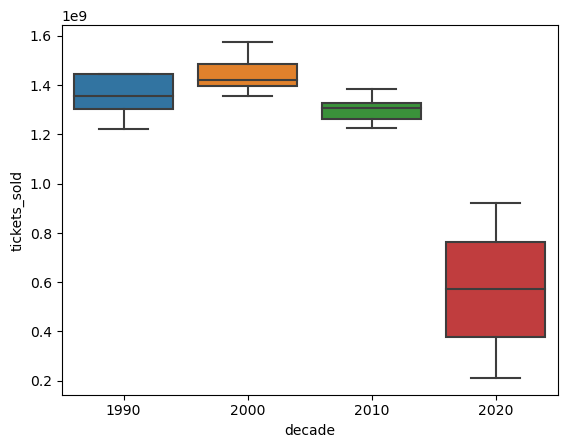

In [30]:
sns.boxplot(data=df_plot, x='decade', y='tickets_sold')

<Axes: xlabel='year', ylabel='box office revenue ($bn)'>

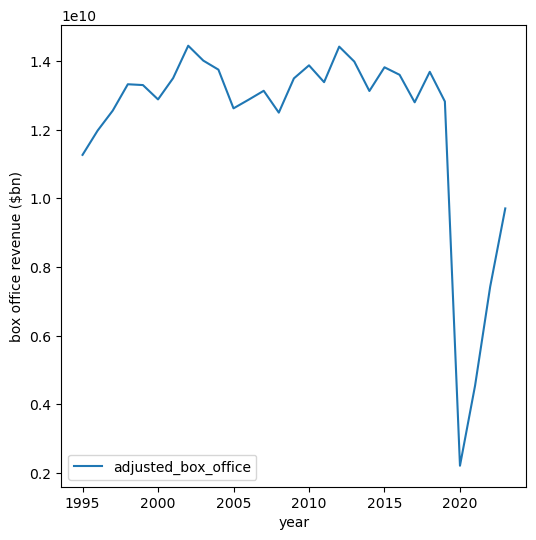

In [31]:
#effect of covid on tickets sold
(
    df_theater_sales
    .plot(kind='line', x='year', y='adjusted_box_office', ylabel='box office revenue ($bn)', figsize=(6,6) )
)

<Axes: xlabel='year', ylabel='number of tickets sold (billions)'>

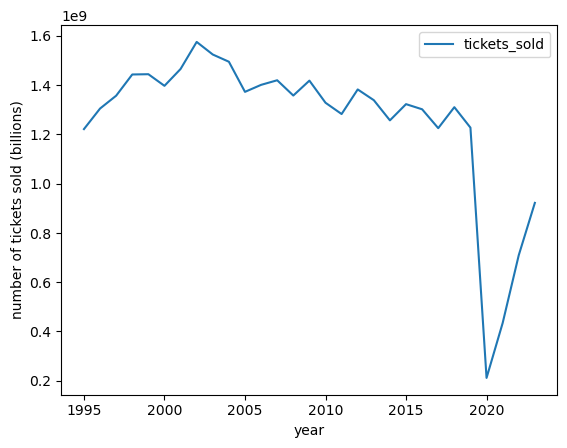

In [32]:
#effect of covid on tickets sold
(
    df_theater_sales
    .plot(kind='line', x='year', y='tickets_sold', ylabel='number of tickets sold (billions)')
)